In [1]:
# ECE661 HW4
# Zhengxin Jiang
# jiang839

import cv2
import numpy as np
import matplotlib . pyplot as plt
import math
import random


### function definetion ###

# The function turn a image into grayscale and normalize it
def imgToGray(img):
    
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_ = img_.astype(np.float64)
    img_ -= img_.min()
    img_ /= img_.max()
    
    return img_

# The function run harris corner detection on an image
# and return the indices of interest points and the marked image
def harris(img, sigma):
    
    # get the gray scale image and normolize it
    img_ = imgToGray(img)
    
    height = img_.shape[0]   
    width = img_.shape[1]    
    matrix_R = np.zeros((height,width))
    
    # The haar kernel
    N_haar = math.ceil(sigma*2)*2
    
    haar_x = np.ones((N_haar, N_haar))
    haar_x[:, :int(N_haar/2)] = -1
    
    haar_y = np.ones((N_haar, N_haar))
    haar_y[:int(N_haar/2), :] = -1

    # derivatives
    dx = cv2.filter2D(img_, ddepth=-1, kernel=haar_x) 
    dy = cv2.filter2D(img_, ddepth=-1, kernel=haar_y)
    
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxy = dx*dy
    
    # Take the sum
    N_sum = math.ceil(sigma*5)
    if N_sum%2 == 0:
        N_sum += 1
    sum_kernel = np.ones((N_sum, N_sum))
    sum_offset = N_sum // 2
    
    sum_dx2 = cv2.filter2D(dx2, ddepth=-1, kernel=sum_kernel) 
    sum_dy2 = cv2.filter2D(dy2, ddepth=-1, kernel=sum_kernel) 
    sum_dxy = cv2.filter2D(dxy, ddepth=-1, kernel=sum_kernel) 
    
    # Calculate the R matrix
    trace = sum_dx2 + sum_dy2
    det = sum_dx2*sum_dy2 - sum_dxy*sum_dxy

    k_vals = det / (trace ** 2 + 0.001)
    k = np.sum(k_vals) / (height*width)

    R = det - k*trace**2
    thresh = np.sort(R.flatten())[-int(len(R.flatten())*0.1)]
    
    idx = []
    
    # find corners
    for i in range(sum_offset, width - sum_offset):
        for j in range(sum_offset, height - sum_offset):
            
            window = R[j-sum_offset: j+sum_offset, i-sum_offset: i+sum_offset]
            if R[j, i] == window.max() and R[j, i]>thresh:
                idx.append([j, i])
                
    # mark corners on the image
    img_mark = img.copy()
    
    for idx_ in idx:    
        cv2.circle(img_mark,(idx_[1],idx_[0]),3,(0,0,255))
   
    return idx, img_mark


# The function finds correspondence points between two marked images 
def harris_corr(img_1, coord1, img_2, coord2, M = 11, method = 'ssd'):
    
    img1 = imgToGray(img_1)
    img2 = imgToGray(img_2)
    img_comb = np.concatenate((img_1, img_2), axis=1)
    
    offset = M//2
    height1 = img1.shape[0]   
    width1 = img1.shape[1]
    height2 = img2.shape[0]   
    width2 = img2.shape[1]
    
    # find correspondences
    for c1 in coord1:
        
        if c1[0]>offset and c1[0]<height1-offset and c1[1]>offset and c1[1]<width1-offset:         
            dist_arr = []
            window1 = img1[c1[0]-offset: c1[0]+offset, c1[1]-offset: c1[1]+offset]
        
            # for each point in image1 find the best match in image2
            for c2 in coord2:        
                if c2[0]>offset and c2[0]<height1-offset and c2[1]>offset and c2[1]<width1-offset:
                    window2 = img2[c2[0]-offset: c2[0]+offset, c2[1]-offset: c2[1]+offset]

                    # compare two windows based on selected method
                    if method == 'ssd':
                        dist = np.sum((window1-window2)**2)
                        
                    elif method == 'ncc':
                        m1 = window1.mean()
                        m2 = window2.mean()
                        
                        t1 = np.sum((window1 - m1) * (window2 - m2))
                        t2 = np.sum((window1 - m1)**2)
                        t3 = np.sum((window2 - m2)**2)
                        
                        dist = 1 - t1/np.sqrt(t2*t3)

                    dist_arr.append(dist)
                    
                else:
                    dist_arr.append(9999)
                
            # coordinate in the combined image    
            c2_match = coord2[np.argsort(dist_arr)[0]]
            c2_match[1] += width1
            
            # draw line with random color
            if (min(dist_arr) < 3 and method == 'ssd') or (min(dist_arr) < 0.5 and method == 'ncc'):
                r = random.randint(0,255)
                g = random.randint(0,255)
                b = random.randint(0,255)
                cv2.line(img_comb,(c1[1],c1[0]),(c2_match[1],c2_match[0]),(b,g,r))
            
    
    return img_comb


# The SIFT method
def sift(img1, img2):
    
    sift1 = cv2.xfeatures2d.SIFT_create()
    sift2 = cv2.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift1.detectAndCompute(img1,None)
    kp2, des2 = sift2.detectAndCompute(img2,None)
    
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    img_res = cv2.drawMatches(img1,kp1,img2,kp2,matches[:200],None,-1)
    
    return img_res
    



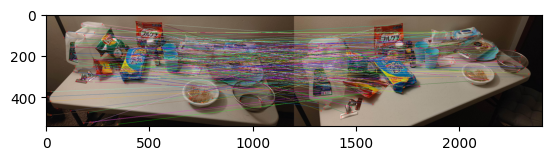

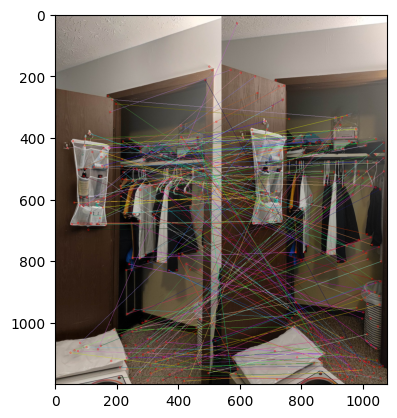

In [22]:
if __name__ == '__main__' :
    
    result_path = 'C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw4/result images/'
    
    # images for task 1
    img_a1 = cv2.imread('HW4-Images/books_1.jpeg')
    img_a2 = cv2.imread('HW4-Images/books_2.jpeg')
    
    img_b1 = cv2.imread('HW4-Images/fountain_1.jpg')
    img_b2 = cv2.imread('HW4-Images/fountain_2.jpg')
    
    selfimg_a1 = cv2.imread('HW4-Images/table1.jpg')
    selfimg_a2 = cv2.imread('HW4-Images/table2.jpg')
    
    selfimg_b1 = cv2.imread('HW4-Images/cloth1.jpg')
    selfimg_b2 = cv2.imread('HW4-Images/cloth2.jpg')
    
    
    ### Task 1.1 ###
#     sigma = 2.6
    
#     harris_coord_a1, img_a1_harris = harris(img_a1, sigma)
#     harris_coord_a2, img_a2_harris = harris(img_a2, sigma)
#     harris_coord_b1, img_b1_harris = harris(img_b1, sigma)
#     harris_coord_b2, img_b2_harris = harris(img_b2, sigma)
    
#     img_a = np.concatenate((img_a1_harris, img_a2_harris), axis=1)
#     cv2.imwrite(result_path + '1.1_a_' + str(sigma) + '.jpg', img_a)
#     img_b = np.concatenate((img_b1_harris, img_b2_harris), axis=1)
#     cv2.imwrite(result_path + '1.1_b_' + str(sigma) + '.jpg', img_b)
    
#     img_a = cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB)   
#     plt.figure()
#     plt.imshow(img_a)
#     img_b = cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB)  
#     plt.figure()
#     plt.imshow(img_b)
    
    
    ### Task 1.2 ###
#     method = 'ncc'
    
#     img_a_corr = harris_corr(img_a1_harris, harris_coord_a1, img_a2_harris, harris_coord_a2)
#     cv2.imwrite(result_path + '1.2_a_' + str(sigma) +'_'+method+ '.jpg', img_a_corr)
    
#     img_a_corr = cv2.cvtColor(img_a_corr,cv2.COLOR_BGR2RGB)   
#     plt.figure()
#     plt.imshow(img_a_corr)
    
#     img_b_corr = harris_corr(img_b1_harris, harris_coord_b1, img_b2_harris, harris_coord_b2)
#     cv2.imwrite(result_path + '1.2_b_' + str(sigma) +'_'+method+ '.jpg', img_b_corr)
    
#     img_b_corr = cv2.cvtColor(img_b_corr,cv2.COLOR_BGR2RGB)   
#     plt.figure()
#     plt.imshow(img_b_corr)
    
    
    ### Task 1.3 SIFT ###
#     img_a_sift = sift(img_a1, img_a2)
#     cv2.imwrite(result_path + '1.3_a_sift' + '.jpg', img_a_sift)
    
#     img_b_sift = sift(img_b1, img_b2)
#     cv2.imwrite(result_path + '1.3_b_sift' + '.jpg', img_b_sift)
    
    
    ### Task 2.1 ###
    sigma = 3.0
    
    harris_coord_a1, img_a1_harris = harris(selfimg_a1, sigma)
    harris_coord_a2, img_a2_harris = harris(selfimg_a2, sigma)
    harris_coord_b1, img_b1_harris = harris(selfimg_b1, sigma)
    harris_coord_b2, img_b2_harris = harris(selfimg_b2, sigma)
    
#     img_a = np.concatenate((img_a1_harris, img_a2_harris), axis=1)
#     cv2.imwrite(result_path + '2.1_a_' + str(sigma) + '.jpg', img_a)
#     img_b = np.concatenate((img_b1_harris, img_b2_harris), axis=1)
#     cv2.imwrite(result_path + '2.1_b_' + str(sigma) + '.jpg', img_b)
    
#     img_a = cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB)   
#     plt.figure()
#     plt.imshow(img_a)
#     img_b = cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB)  
#     plt.figure()
#     plt.imshow(img_b)
    
    
    ### Task 2.2 ###
    method = 'ssd'
    
    img_a_corr = harris_corr(img_a1_harris, harris_coord_a1, img_a2_harris, harris_coord_a2)
    cv2.imwrite(result_path + '2.2_a_' + str(sigma) +'_'+method+ '.jpg', img_a_corr)
    
    img_a_corr = cv2.cvtColor(img_a_corr,cv2.COLOR_BGR2RGB)   
    plt.figure()
    plt.imshow(img_a_corr)
    
    img_b_corr = harris_corr(img_b1_harris, harris_coord_b1, img_b2_harris, harris_coord_b2)
    cv2.imwrite(result_path + '2.2_b_' + str(sigma) +'_'+method+ '.jpg', img_b_corr)
    
    img_b_corr = cv2.cvtColor(img_b_corr,cv2.COLOR_BGR2RGB)   
    plt.figure()
    plt.imshow(img_b_corr)
    
    
    ### Task 2.3 SIFT ###
#     img_a_sift = sift(selfimg_a1, selfimg_a2)
#     cv2.imwrite(result_path + '2.3_a_sift' + '.jpg', img_a_sift)
    
#     img_b_sift = sift(selfimg_b1, selfimg_b2)
#     cv2.imwrite(result_path + '2.3_b_sift' + '.jpg', img_b_sift)
        

    
    
    
    